In [1]:
# prerequisites
import numpy as np
import math as m
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
# from keras import objectives
from scipy.stats import norm


Bad key "text.kerning_factor" on line 4 in
/home/kevin/anaconda3/envs/py3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [5]:
# data load
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
print(x_tr.shape, x_te.shape)

# network parameters
batch_size, n_epoch = 100, 100
n_hidden, z_dim = 256, 2

(60000, 784) (10000, 784)


In [6]:
x_tr.shape[1:]

(784,)

In [7]:
# encoder
x = Input(shape=(x_tr.shape[1:]))
x_encoded = Dense(n_hidden, activation='elu')(x)
x_encoded = Dropout(0.25)(x_encoded)
x_encoded = Dense(n_hidden//2, activation='elu')(x_encoded)
x_encoded = Dropout(0.25)(x_encoded)
x_encoded = Dense(n_hidden//4, activation='tanh')(x_encoded)
x_encoded = Dropout(0.25)(x_encoded)

mean = Dense(z_dim)(x_encoded)
#mu = Dense(z_dim)(x_encoded)

#### Rename log_var to log_stddev
log_stddev = Dense(z_dim)(x_encoded)
#stddev = K.exp(log_stdbdev)
stddev = 0.000001 + K.log(K.exp(log_stddev) + 1)
#### Keep calling this log_var
#log_var = Dense(z_dim)(x_encoded)

In [9]:
x_encoded

<tf.Tensor 'dropout_2/Identity:0' shape=(None, 64) dtype=float32>

In [62]:
# sampling function
##### Fix convention for global variables; remove mean and stddev fixed values.
def sampling(args):
    mean, stddev = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mean + K.exp(stddev) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mean, stddev])
#### Modify this part to sample from coupled gaussians instead of gaussians.

In [11]:
x_tr.shape[1]

784

In [70]:
# decoder
z_decoder1 = Dense(n_hidden//2, activation='tanh')
z_decoder2 = Dense(n_hidden, activation='elu')
y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
z_decoded = Dropout(0.25)(z_decoded)
y = y_decoder(z_decoded)

In [71]:
#### a) Continue the
k = 0.025
d = 20b
d1 = 1 + d * k + 2 * k
marginal_likelihood = tf.reduce_sum(x * tf.subtract(tf.pow(y, (2 * k) / (1 + k)), 1) / (2 * k) + (1 - x)
                                    * tf.subtract(tf.pow(1 - y, (2 * k) / (1 + k)), 1) / (k * 2), 1)
KL_d1 = tf.reduce_prod(tf.pow(2 * tf.constant(m.pi), k / (1 + d * k)) * tf.sqrt(d1 / (d1 - 2 * k * tf.square(stddev)))
                       * tf.exp(tf.square(mean) * d1 * k / (1 + d * k) / (d1 - 2 * k * tf.square(stddev))), 1)
KL_d2 = tf.reduce_prod(tf.pow(2 * tf.constant(m.pi) * tf.square(stddev),
                              k / (1 + k * d)) * tf.sqrt(d1 / (1 + d * k)), 1)
KL_divergence = (KL_d1 - KL_d2) / k / 2
ml = marginal_likelihood
marginal_likelihood = tf.reduce_mean(marginal_likelihood)

In [10]:
m

<module 'math' from '/home/kevin/anaconda3/envs/py3.7/lib/python3.7/lib-dynload/math.cpython-37m-x86_64-linux-gnu.so'>

In [72]:
# loss
#reconstruction_loss = objectives.binary_crossentropy(x, y) * x_tr.shape[1]
#kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
ELBO = marginal_likelihood - KL_divergence
vae_loss = -ELBO

#vae_loss = reconstruction_loss + kl_loss

# build model
vae = Model(x, y)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_65 (Dense)                (None, 256)          200960      input_10[0][0]                   
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 256)          0           dense_65[0][0]                   
__________________________________________________________________________________________________
dense_66 (Dense)                (None, 128)          32896       dropout_28[0][0]                 
___________________________________________________________________________________________

In [73]:
# train
vae.fit(x_tr,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te, None), verbose=1)

Epoch 1/10
600/600 [==============================] - 5s 8ms/step - loss: 191.8423 - val_loss: 176.2183
Epoch 2/10
600/600 [==============================] - 5s 8ms/step - loss: 177.6145 - val_loss: 173.9695
Epoch 3/10
600/600 [==============================] - 5s 8ms/step - loss: 176.3927 - val_loss: 172.9628
Epoch 4/10
600/600 [==============================] - 5s 8ms/step - loss: 175.9231 - val_loss: 172.7795
Epoch 5/10
600/600 [==============================] - 5s 8ms/step - loss: 175.6997 - val_loss: 172.4458
Epoch 6/10
600/600 [==============================] - 5s 8ms/step - loss: 175.4759 - val_loss: 172.2975
Epoch 7/10
600/600 [==============================] - 5s 8ms/step - loss: 175.2450 - val_loss: 172.3099
Epoch 8/10
600/600 [==============================] - 5s 8ms/step - loss: 175.1683 - val_loss: 172.5244
Epoch 9/10
600/600 [==============================] - 5s 8ms/step - loss: 174.9723 - val_loss: 171.9821
Epoch 10/10
600/600 [==============================] - 5s 8ms/st

In [74]:
# build encoder
encoder = Model(x, mean)
encoder.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_65 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_28 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0  

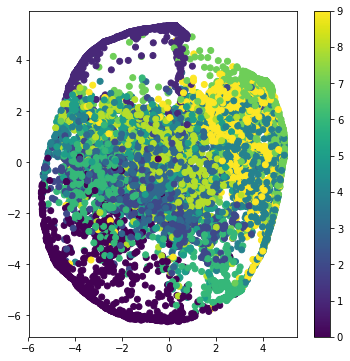

In [75]:
# Plot of the digit classes in the latent space
x_te_latent = encoder.predict(x_te, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te)
plt.colorbar()
plt.show()

In [76]:
# build decoder
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_74 (Dense)             multiple                  384       
_________________________________________________________________
dense_75 (Dense)             multiple                  33024     
_________________________________________________________________
dense_76 (Dense)             multiple                  201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


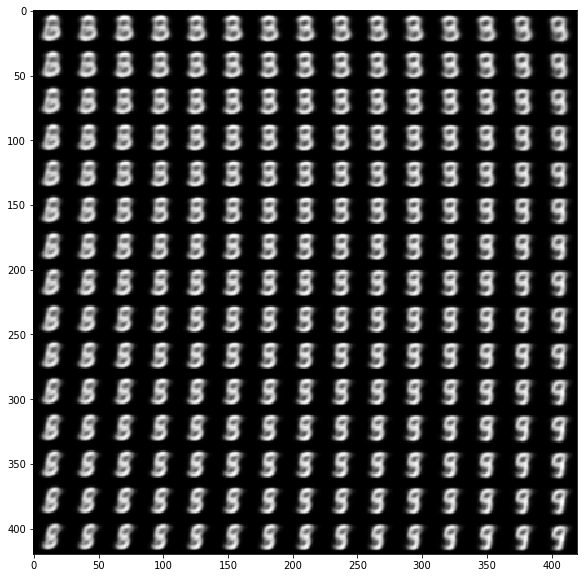

In [77]:
# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()